In [44]:
#Build a randomForest model to classify survivors, use k-fold cross-validation to tune model parameters 
#(e.g. N_estimators, max_depth, max_features). You should build a grid for different combination of model 
#parameters and evaluate the parameter set by looking at the best average AUC value.

#Use your best set of parameters to train the model on the entire training dataset, apply the model to 
#test dataset to evaluate the result.

#Compare the performance between logistic regression and randomForest.

#Output the importance of features based on randomForest model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [45]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [46]:
data_train['Title'] = data_train['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
data_train['Title'] = data_train['Title'].map(Title_Dictionary)

In [47]:
fill_mean = lambda g: g.fillna(g.mean())
data_train['Age'] = data_train.groupby(['Sex', 'Title', 'Pclass'])['Age'].apply(fill_mean)

In [48]:
data_train.Age = data_train.groupby(['Sex', 'Title', 'Pclass'])['Age'].apply(fill_mean)

data_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [49]:
from sklearn.model_selection import train_test_split

data_train['Sex'] = data_train['Sex'].map({'male':1, 'female':0})


X_all = data_train[['Pclass','Sex','Age']]
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test)
print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(712, 3) (179, 3)
(712,) (179,)


In [50]:
X_train.head()

,Pclass,Sex,Age
784,3,1,25.000000
413,2,1,32.768293
852,3,0,9.000000
129,3,1,45.000000
608,2,0,22.000000


In [51]:
X_test.head()

,Pclass,Sex,Age
720,2,0,6.000000
385,2,1,18.000000
564,3,0,16.123188
389,2,0,17.000000
750,2,0,4.000000


In [52]:
y_train.head()

784    0
413    0
852    0
129    0
608    1
Name: Survived, dtype: int64

In [53]:
y_train.dtypes

dtype('int64')

In [54]:
y_test.dtypes

dtype('int64')

In [55]:
data_train = pd.get_dummies(data_train, columns=['Sex','Embarked'])

In [56]:
# k-fold with index pair return
def kfold_index(x_train, k):
    if k < 1:
        print('K cannot smaller than 1')
        return
    else:
        l = x_train.shape[0]
        tail = l % k
        q = l // k
        index = [0]
        output_index = []
        # first n_examples % k sub_example have n_examples // k + 1 elements
        for i in range(1,tail):
            index.append((i*q)+1)
        for j in range(tail,k+1):
            index.append(j*q+tail)
        for m in range(len(index)-1):
            output_index.append([index[m],index[m+1]])
        #print(output_index)
        return output_index

In [57]:
# k-fold cross validation
def train_validation_split(data, k):
    number_of_rows = data.shape[0]
    number_of_test = int(np.floor(number_of_rows / k))
    list_of_data_index = [i for i in range(number_of_rows)]
    
    result = pd.DataFrame(columns=['train_index','validation_index'], index=[i for i in range(k)])
    
    for i in range(k):
        total_index = np.array([i for i in range(number_of_rows)])
        test_index = np.random.choice(list_of_data_index, size=number_of_test, replace=False)
        train_index = np.delete(total_index, test_index)
        
        for index in test_index:
            list_of_data_index.remove(index)
        
        result.iloc[i,0] = np.sort(train_index)
        result.iloc[i,1] = np.sort(test_index)

    return result

In [58]:
def combination_grid(parameters):
    import itertools
    combinations = list(itertools.product(*list(parameters.values())))
    df = pd.DataFrame(combinations, columns = parameters.keys()) 
    
    return df

In [59]:
# spliting 6-fold train_validation
split = train_validation_split(X_all, 6)
split

,train_index,validation_index
0,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...","[0, 2, 14, 27, 28, 43, 51, 52, 54, 69, 74, 80,..."
1,"[0, 1, 2, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, ...","[3, 4, 8, 10, 32, 34, 62, 64, 76, 85, 90, 97, ..."
2,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[6, 16, 17, 31, 33, 36, 37, 42, 50, 53, 65, 67..."
3,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...","[7, 20, 21, 29, 39, 44, 46, 48, 55, 56, 57, 59..."
4,"[0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 16, ...","[1, 5, 9, 15, 18, 19, 22, 24, 25, 38, 40, 47, ..."
5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16,...","[11, 12, 13, 23, 26, 30, 35, 41, 45, 58, 72, 7..."


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }


acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

combina_grid = combination_grid(parameters)
combina_grid

,n_estimators,max_features,criterion,max_depth,min_samples_split,min_samples_leaf
0,4,log2,entropy,2,2,1
1,4,log2,entropy,2,2,5
2,4,log2,entropy,2,2,8
3,4,log2,entropy,2,3,1
4,4,log2,entropy,2,3,5
...,...,...,...,...,...,...
643,9,auto,gini,10,3,5
644,9,auto,gini,10,3,8
645,9,auto,gini,10,5,1
646,9,auto,gini,10,5,5


In [61]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7988826815642458


In [62]:
#fitting k-nearest neighbours algorithm
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(X_train,y_train)
y_pred = knn1.predict(X_test)

In [63]:
#calculating accuracy
from sklearn.metrics import accuracy_score
print('Acuuracy score is {}'.format(accuracy_score(y_test, y_pred)))

Acuuracy score is 0.7877094972067039


In [64]:
from sklearn.model_selection import cross_val_score
#hyper parameter tuning.Selecting best K
neighbors = [x for x in range(1,50) if x % 2 != 0]
# empty list that will hold cv scores
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_all, y_all, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

5


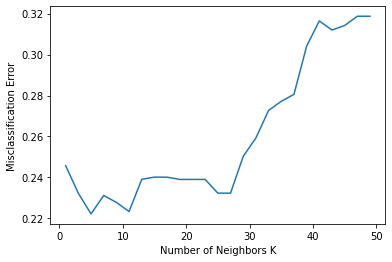

In [65]:
#graphical view
#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_k_index = MSE.index(min(MSE))
optimal_k = neighbors[optimal_k_index]
print(optimal_k)
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

### The best k value for k nearest neighbours is k=5. So we train a model based on

In [66]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_pred = knn1.predict(X_test)
y_pred

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1], dtype=int64)

In [ ]:
# the evaluation method here is accuracy
def cv(model, x_train, y_train, k):
    # get kfold index
    index = kfold_index(x_train, k)
    #train each sub-combination
    auc = []
    for i in range(k):
        cv_xtest = x_train.iloc[index[i][0]:index[i][1],:]
        cv_ytest = y_train.iloc[index[i][0]:index[i][1],]
        # drop the test sub-set
        cv_xtrain = x_train.drop(x_train.index[index[i][0]:index[i][1]])
        cv_ytrain = y_train.drop(y_train.index[index[i][0]:index[i][1]])
        model.fit(cv_xtrain,cv_ytrain.values.reshape(-1))
        y_pred = model.predict(cv_xtest)
        # calculate the auc as the evaluation metric
        fpr, tpr, threshold = roc_curve(cv_ytest, rtree.predict_proba(cv_xtest)[:,1])
        aa = metrics.auc(fpr, tpr)
        auc.append(aa)
    return np.mean(auc)